# Exercise 07 Clustering I - Solution

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

### Import libraries

In [1]:
# import all libraries used in this notebook here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'

## Part 1. K-Means Clustering

This part we will perform clustering on a customer dataset provided by a mall. You can find the `Mall_Customers.csv` on the Learn platform. The goal is to explore if there are natural clusters in the customers that can be considered as different customer profiles and inform the marketing strategies of the mall.

### Load the dataset

Download the `Mall_Customers.csv` and load it.

In [2]:
# load dataset
df = pd.read_csv('Mall_Customers.csv')

### Explore the dataset

The goal of clustering is to discover the hidden sturcture in the dataset. Therefore, understanding the dataset is critical to set the clustering algorithm and interpret the clustering results.

We can explore the dataset to obtain the basic information and descriptive statistics. It's also important to understand the interactions between different features.

Based on the exploration, we may find clues to determine whether to:
- Delete some of the features
- Perform feature scaling
- Eliminate outliers
- ...

In [3]:
# display the first 5 rows
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


There are 5 columns in the dataset.

Except for the 'Gener' column, which is a categorical varialbe, the other 4 columns are numerics variables.

In [4]:
# display the basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


There are 200 instances in the dataset.

There is no missing values.

In [5]:
# display the descriptive statistics of numeric variables
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


The scales of different features are similar, there is no need to perform feature scaling.

The 'CustomerID' seems to be a unique ID for each customer, ranging from 1 to 200.

It might not be a good feature for clustering, since we cannot assess the similarity between two customers based on their IDs, unless the 'CustomerID' carries other useful information.

In [6]:
# display the correlation matrix between numeric variables
corr = df.corr(numeric_only = True)
corr.style.background_gradient(cmap = 'coolwarm')

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,1.000000,-0.026763,0.977548,0.013835
Age,-0.026763,1.000000,-0.012398,-0.327227
Annual Income (k$),0.977548,-0.012398,1.000000,0.009903
Spending Score (1-100),0.013835,-0.327227,0.009903,1.000000


There is no strong correlation among 'Age', 'Annual Income', and 'Spending Score'.

However, the correlation coefficient between 'CustomerID' and 'Annual Income' is close to 1.

It seems that the mall assigns IDs based on the customer's annual income level.

We can check this assumption by creating a scatter polt between 'CustomerID' and 'Annual Income'.

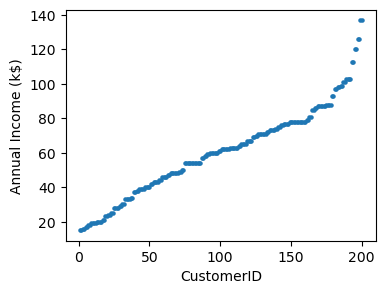

In [7]:
# display the scatter plot of 'CustomerID' vs ' Annual Income'
df.plot.scatter(
    x = 'CustomerID',
    y = 'Annual Income (k$)',
    figsize = (4, 3),
    marker = '.'
)
plt.show()

Our assumption is correct. In such case, 'CustomerID' can be useful for clustering, but we can use 'Annual Income' as the input feature directly.

So it's better to eliminate the 'CustomerID' column from the inputs to clustering altorithms, or assign the 'CustomerID' column as the index of the `DataFrame`.

Gender is a categorical variable, which divides the dataset into two natural clusters. However, to better understand the customers, simply clustering the customers into two groups based on gender is not enough.

There are two potential directions we can proceed to explore the hidden pattern in the dataset:
1. Perform clustering for each gender respectively to see if there are natural clusters within each gender.
2. Perform clustering on the entire dataset to see if there are natural clusters regardless gender.

Which direction to choose depends on whether 'Age', 'Annual Income', and 'Spending Score' differ for different genders.

We can check whether this difference exists by creating [boxplots](https://en.wikipedia.org/wiki/Box_plot) of 'Age', 'Annual Income', and 'Spending Score' by gender.

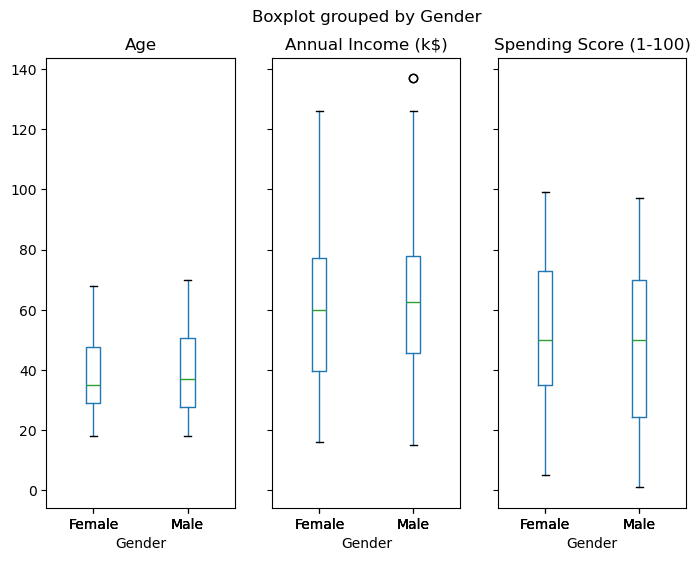

In [8]:
# display the boxplot of 'Age', 'Annual Income', 'Spending Score' by gender
df.boxplot(
    column = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)'],
    by = 'Gender',
    grid = False,
    figsize = (8, 6),
    layout = (1, 3)
)
plt.show()

The boxplots show that there are no significant differences between the distributions of 'Age', 'Annual Income', and 'Spending Score' between different genders.

But there might be differences between the interactions among the 3 features between different genders.

But the interaction between these three features may differ between genders.

We can check whether this difference exists by creating pair-wise scatter plots between these three features by gender.

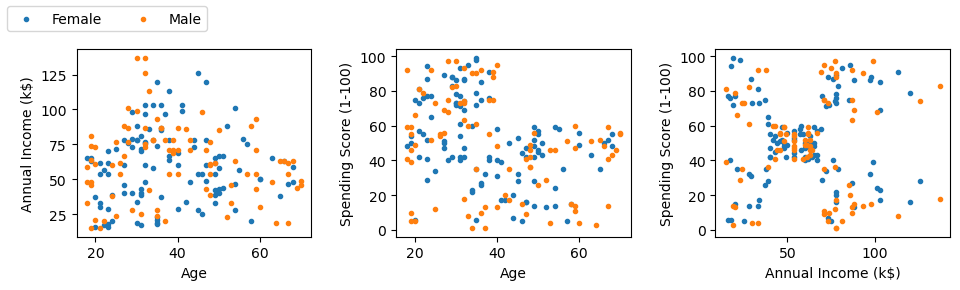

In [9]:
# display pair-wise scatter plots by gender
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 3))
fig.tight_layout(pad = 3)
# scatter plot 'Age' vs 'Annual Income' by gender
axs[0].scatter(
    df[df['Gender'] == 'Female']['Age'],
    df[df['Gender'] == 'Female']['Annual Income (k$)'],
    marker = '.',
    label = 'Female'
)
axs[0].scatter(
    df[df['Gender'] == 'Male']['Age'],
    df[df['Gender'] == 'Male']['Annual Income (k$)'],
    marker = '.',
    label = 'Female'
)
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Annual Income (k$)')
# scatter plot 'Age' vs 'Spending Score' by gender
axs[1].scatter(
    df[df['Gender'] == 'Female']['Age'],
    df[df['Gender'] == 'Female']['Spending Score (1-100)'],
    marker = '.',
    label = 'Female'
)
axs[1].scatter(
    df[df['Gender'] == 'Male']['Age'],
    df[df['Gender'] == 'Male']['Spending Score (1-100)'],
    marker = '.',
    label = 'Female'
)
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Spending Score (1-100)')
# scatter plot 'Annual Income' vs 'Spending Score' by gender
axs[2].scatter(
    df[df['Gender'] == 'Female']['Annual Income (k$)'],
    df[df['Gender'] == 'Female']['Spending Score (1-100)'],
    marker = '.',
    label = 'Female'
)
axs[2].scatter(
    df[df['Gender'] == 'Male']['Annual Income (k$)'],
    df[df['Gender'] == 'Male']['Spending Score (1-100)'],
    marker = '.',
    label = 'Female'
)
axs[2].set_xlabel('Annual Income (k$)')
axs[2].set_ylabel('Spending Score (1-100)')
fig.legend(['Female', 'Male'], loc = 'upper left', ncol = 2)
plt.show()

The pair-wise scatter plots show that there are no significant differences in feature interactions between different genders.

So it is ok to eliminate the 'Gender' column from the dataset before clustering to see if there are natural clusters regardless gender.

### Data pre-processing

Based on the conclusions we got after exploring the dataset, we need to:
- Convert 'CustomerID' to the index of the `DataFrame`
- Delete 'Gender' from the dataset

In [10]:
# set 'CustomerID' as the index of the DataFrame
df.set_index(['CustomerID'], inplace = True)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [11]:
# eliminate 'Gender' from the dataset
df.drop(columns = ['Gender'], inplace = True)
df.head()

,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,
1,19,15,39
2,21,15,81
3,20,16,6
4,23,16,77
5,31,17,40


### K-Means clustering

After preprocessing, we can using K-Means algorithm to perform clustering. We need to specify the number of clusters we need. We can start with the default value (K = 10).

In [12]:
# K-Means clustering
X = df.values
model = KMeans(
    n_clusters = 10, # 10 clusters
    n_init = 'auto', # multiple attempt with different initial centroids
    random_state = 1, # fix ramdom state to guarantee reproducibility
    verbose = 1 # output log
)
model.fit(X)

Initialization complete
Iteration 0, inertia 59614.0.
Iteration 1, inertia 44229.10477800053.
Iteration 2, inertia 43536.34227357067.
Iteration 3, inertia 43326.358692798865.
Iteration 4, inertia 43014.97281959938.
Iteration 5, inertia 42485.212002260174.
Iteration 6, inertia 42336.71050698183.
Iteration 7, inertia 42293.181497021505.
Converged at iteration 7: strict convergence.


KMeans(n_clusters=10, n_init='auto', random_state=1, verbose=1)

In [13]:
# obtain the cluster centers
model.cluster_centers_

array([[ 27.27272727,  30.72727273,  68.36363636],
       [ 49.        ,  24.46153846,  11.07692308],
       [ 46.16      ,  61.32      ,  46.36      ],
       [ 32.69230769,  86.53846154,  82.12820513],
       [ 41.        ,  80.18181818,  12.68181818],
       [ 23.74074074,  58.66666667,  49.33333333],
       [ 41.        , 109.7       ,  22.        ],
       [ 36.30769231,  31.69230769,  36.46153846],
       [ 24.61538462,  23.76923077,  85.76923077],
       [ 61.44444444,  51.18518519,  50.44444444]])

In [14]:
# obtain clustering results
model.labels_

array([7, 8, 1, 8, 7, 8, 1, 8, 1, 0, 1, 8, 1, 8, 1, 8, 7, 0, 1, 8, 7, 0,
       1, 0, 1, 8, 7, 0, 7, 8, 1, 0, 1, 8, 1, 8, 1, 0, 7, 0, 9, 8, 7, 0,
       7, 0, 9, 7, 7, 7, 9, 0, 5, 9, 9, 7, 9, 9, 5, 9, 9, 5, 9, 9, 9, 5,
       2, 9, 5, 5, 9, 2, 9, 9, 9, 5, 2, 2, 5, 2, 9, 2, 9, 2, 5, 2, 9, 5,
       5, 2, 9, 5, 2, 2, 5, 5, 2, 5, 2, 5, 5, 2, 9, 5, 2, 5, 9, 2, 9, 9,
       9, 5, 2, 5, 5, 5, 9, 2, 2, 2, 5, 2, 2, 3, 5, 3, 2, 3, 4, 3, 4, 3,
       5, 3, 4, 3, 4, 3, 4, 3, 4, 3, 5, 3, 4, 3, 2, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 2, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 6, 3, 6, 3, 6, 3, 6, 3, 6, 3, 6, 3, 6, 3, 6, 3, 6, 3,
       6, 3], dtype=int32)

In [15]:
# obtain the inertia
model.inertia_

42293.181497021505

### Select K value through Elbow method

Different values of K will lead to different results. Without any prior knowledge, it is difficult to assume a proper K value. We can use Elbow method to select K value based on a specified metric.

`sklearn` use inertia as the default criteria to determine when the model converge. We can also use inertia to select the value of K.

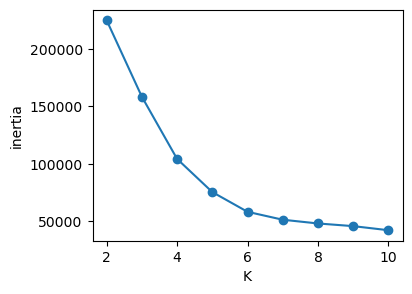

In [16]:
# create an empty list to store inertia
inertia =[]

# test different k values
for k in range(2, 11):
    model = KMeans(
        n_clusters = k,
        n_init = 'auto',
        random_state = 1,
        verbose = 0
    ).fit(X)
    inertia.append(model.inertia_)

# plot k vs inertia
plt.figure(figsize = (4, 3))
plt.plot(range(2, 11), inertia, marker = 'o')
plt.xlabel('K')
plt.ylabel('inertia')
plt.show()

The figure shows that the inertia decreases as k increases.

However, instead of having a sharp elbow, we got a gentle curve. The location of the elbow point is not clear.

In such cases, identifying the elbow point is more of an art than a science, which can be subjective.

One option is to use another metric to see if there is a clearer elbow point.

Let's try Silhouette Coefficient, Calinski-Harabasz Index and Davies-Bouldin Index

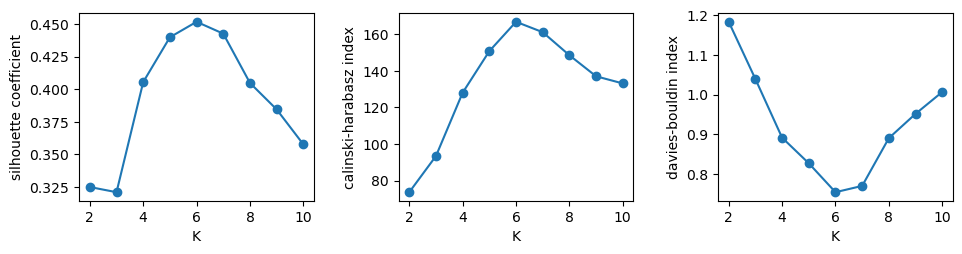

In [17]:
# create an empty list to store silhouette coefficient
silhouette = []
calinski_harabasz = []
davies_bouldin = []

# test different k values
for k in range(2, 11):
    model = KMeans(
        n_clusters = k,
        n_init = 'auto',
        random_state = 1,
        verbose = 0
    ).fit(X)
    silhouette.append(silhouette_score(X, model.labels_))
    calinski_harabasz.append(calinski_harabasz_score(X, model.labels_))
    davies_bouldin.append(davies_bouldin_score(X, model.labels_))

# plot k vs silhouette coefficient
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 3))
fig.tight_layout(pad = 3)
axs[0].plot(range(2, 11), silhouette, marker = 'o')
axs[0].set_xlabel('K')
axs[0].set_ylabel('silhouette coefficient')
axs[1].plot(range(2, 11), calinski_harabasz, marker = 'o')
axs[1].set_xlabel('K')
axs[1].set_ylabel('calinski-harabasz index')
axs[2].plot(range(2, 11), davies_bouldin, marker = 'o')
axs[2].set_xlabel('K')
axs[2].set_ylabel('davies-bouldin index')
plt.show()

Considering the four metrics, 6 is a more appropriate value for K.

In [18]:
# reconstruct the clustering model with k=6
model = KMeans(
    n_clusters = 6,
    n_init = 'auto',
    random_state = 1,
    verbose = 1
)
model.fit(X)

Initialization complete
Iteration 0, inertia 94472.0.
Iteration 1, inertia 60989.20325428604.
Iteration 2, inertia 58638.141444971836.
Iteration 3, inertia 58392.74666281145.
Iteration 4, inertia 58365.08098926272.
Iteration 5, inertia 58316.48776223776.
Converged at iteration 5: strict convergence.


KMeans(n_clusters=6, n_init='auto', random_state=1, verbose=1)

### Interpret the results

After we got the clustering results, the most important step is to try to interpret the results.

To understand these natural clusters, the easiest way is to visualize the results.

In [20]:
# create an interactive 3D scatter plot using plotly
fig = px.scatter_3d(
    df,
    x = 'Annual Income (k$)',
    y = 'Spending Score (1-100)',
    z = 'Age',
    color = model.labels_
)
fig.show()

From the visualization we can see, there are 6 clusters in total:
- Cluster 0: low annual income, high spending score
- Cluster 1: low annual income, low spending score
- Cluster 2: median annual income, median spending score, old customer
- Cluster 3: high annual income, low spending score
- Cluster 4: high annual income, high spending score
- Cluster 5: median annual income, median spending socre, young customer

For the mall, cluster 2 and cluster 5 may not be considered two different categories of customers.

We can try to reduce the number of clusters to 5.

In [21]:
# reconstruct the clustering model with k=6
model = KMeans(
    n_clusters = 5,
    n_init = 'auto',
    random_state = 1,
    verbose = 1
)
model.fit(X)

# create an interactive 3D scatter plot using plotly
fig = px.scatter_3d(
    df,
    x = 'Annual Income (k$)',
    y = 'Spending Score (1-100)',
    z = 'Age',
    color = model.labels_
)
fig.show()

Initialization complete
Iteration 0, inertia 108689.0.
Iteration 1, inertia 77746.9461658028.
Iteration 2, inertia 75580.07321148856.
Iteration 3, inertia 75534.94959838685.
Iteration 4, inertia 75493.84464013917.
Converged at iteration 4: strict convergence.


Now we have 5 clusters, the clustering results seem to make sense in the visualization.

We can regard these clusters as different customer profiles, and develop targeted marketing strategies.

However, if there are more than 3 features, it would be impossible to create a 3D visualization.

In such cases, we need to have a close look at the distributions of different features in each cluster. This can also help us understand the clusters we got.

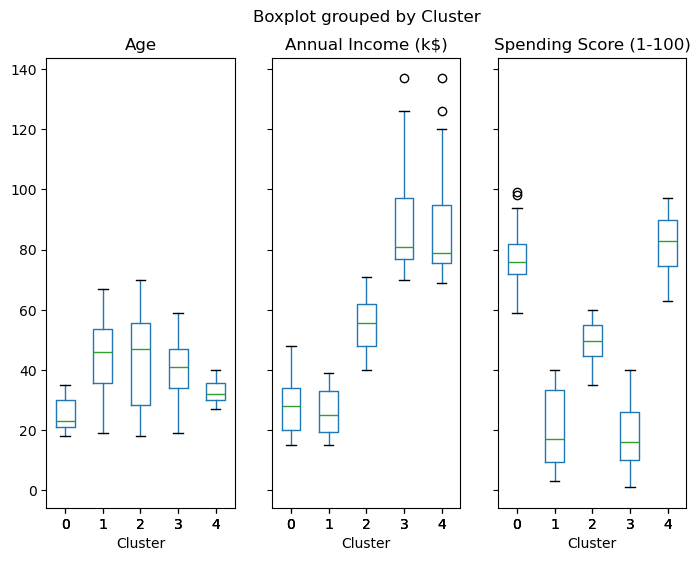

In [22]:
# display the boxplot of 'Age', 'Annual Income', 'Spending Score' by cluster
labeled_df = df.copy()
labeled_df['Cluster'] = model.labels_
labeled_df.boxplot(
    column = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)'],
    by = 'Cluster',
    grid = False,
    figsize = (8, 6),
    layout = (1, 3)
)
plt.show()

We can try to characterize the customer profiles represented by each cluster based on the above boxplot:
- Cluster 0: around 20 to 30 years old, low annual income, high spending score
- Cluster 1: around 35 to 55 years old, low annual income, low spending score
- Cluster 2: across all ages, median annual income, median spending score
- Cluster 3: around 35 to 50 years old, high annual income, low spending score
- Cluster 4: around 30 to 40 years old, high annual income, high spending score

Or we can use the centroids to represent each customer profiles if the clusters are compact enough.

In [23]:
# formalize cluster centroids
cluster_centers = pd.DataFrame(
    model.cluster_centers_,
    columns = df.columns
)
cluster_centers

,Age,Annual Income (k$),Spending Score (1-100)
0,24.960000,28.040000,77.000000
1,45.217391,26.304348,20.913043
2,43.934211,55.210526,49.447368
3,40.324324,87.432432,18.189189
4,32.692308,86.538462,82.128205


### Make predictions

Given an unseen customer, if we know her or his age, annual income level and spending score, then we can use the learned model to assign this customer into one cluster.

In [24]:
# define a new customer
new_data = pd.DataFrame(
    {
        'Age': [31],
        'Annual Income (k$)': [59],
        'Spending Score (1-100)': [17]
    }
)
new_data

,Age,Annual Income (k$),Spending Score (1-100)
0,31,59,17


In [25]:
# assign this customer into one cluster
model.predict(new_data.values)

array([3], dtype=int32)

## Part 2. Hands-on Exercise

In this exercise, we will perform K-Means clustering with the [California Housing dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset).

Unlike the exercises we've done before:
- Regression: predict the median house value for different California districts
- Classification: classify California districts into different categories with different median house value
We will perform clustering with this dataset to see if there are natrual clusters among different California districts and what does these clusters represent.

First, let's load the dataset.

In [26]:
# load the dataset
feature_df, target_df = datasets.fetch_california_housing(return_X_y = True, as_frame = True)
# merge the features and target into one DataFrame for the following clustering
data_df = feature_df.copy()
data_df['MedHouseVal'] = target_df
data_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


<span style="color:red">**[TBC]**</span> As we already loaded the dataset, please complete the following tasks:
- Data exploration
- Data pre-processing
- K-Means clustering
- Interpret clustering results

### Task 1. Data exploration

<span style="color:red">**[TBC]**</span> Perform data exploration to see if there is a need for:
- Eliminate records with missing-values
- Eliminate highly correlated features
- Eliminate irrelevant / useless features
- Feature scaling
- Eliminate outliers

In [27]:
# [TBC] complete your code here with proper comments
# display the basic information
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


There is no missing values to be delete.

In [28]:
# [TBC] complete your code here with proper comments
# display the descriptive statistics of numeric variables
data_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Different features have different scales, like 'Population' and 'MedInc'. If such features are retained for the following clustering, feature scaling need to be performed first.

In [29]:
# [TBC] complete your code here with proper comments
# display the correlation matrix between numeric variables
corr = data_df.corr(numeric_only = True)
corr.style.background_gradient(cmap = 'coolwarm')

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
MedHouseVal,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


'AveRooms' and 'AveBedrms' are highly positively correlated. We could keep only 'AveRooms' and eliminate 'AveBedrms'.

'Latitude' and 'Longitude' are highly negatively correlated. However, the correlation coefficients between these two features and other features are all close to zero.
- The negative correlation between 'Latitude' and 'Longitude' may be determined by the geographic shape of California.
- The other features of the blockgroups are saptially homogeneous.

So it's bettet to eliminate 'Latitude' and 'Longitude' too.

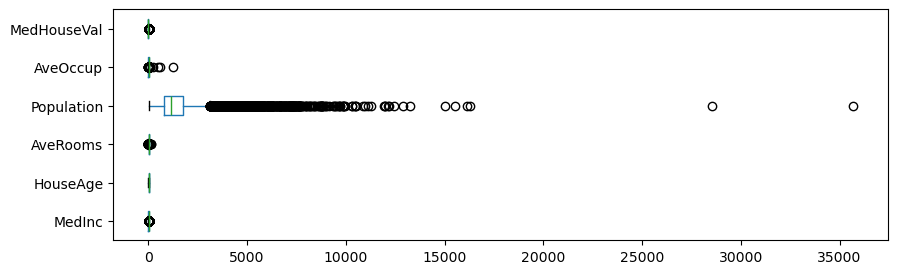

In [30]:
# [TBC] complete your code here with proper comments
# display the boxplot of the remained features
data_df.boxplot(
    column = ['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'MedHouseVal'],
    grid = False,
    figsize = (10, 3),
    vert = False
)
plt.show()

The boxplots show that the scales of remained features are very different.

It might be better to perform feature scaling before clustering, as the clustering is based on distances

The boxplots show that there are a lot of outliers in the dataset, which may affect the clustering results.

So it might be better to eliminate outliers or keep them.

### Task 2. Data preprocessing

<span style="color:red">**[TBC]**</span> Depending on the conclusions you got from data exploration, preproces the dataset.

In [31]:
# [TBC] complete your code here with proper comments
# eliminate 'AvdBedrms', 'Latitude', and 'Longitude'
data_df.drop(columns = ['AveBedrms', 'Latitude', 'Longitude'], inplace = True)
data_df.head()

,MedInc,HouseAge,AveRooms,Population,AveOccup,MedHouseVal
0,8.3252,41.0,6.984127,322.0,2.555556,4.526
1,8.3014,21.0,6.238137,2401.0,2.109842,3.585
2,7.2574,52.0,8.288136,496.0,2.802260,3.521
3,5.6431,52.0,5.817352,558.0,2.547945,3.413
4,3.8462,52.0,6.281853,565.0,2.181467,3.422


In [32]:
# [TBC] complete your code here with proper comments
# calculate the 1% and 99% quantiles to locate the extremly small or large values
quantiles_1 = data_df.quantile(0.01)
quantiles_99 = data_df.quantile(0.99)
# eliminate extremly small or large values
preprocessed_data_df = data_df.copy()
for column in preprocessed_data_df.columns:
    preprocessed_data_df = preprocessed_data_df[
        (preprocessed_data_df[column] > quantiles_1[column]) &
        (preprocessed_data_df[column] < quantiles_99[column])
    ]
print("The number of outliers that are eliminated:", len(data_df) - len(preprocessed_data_df))

The number of outliers that are eliminated: 3601


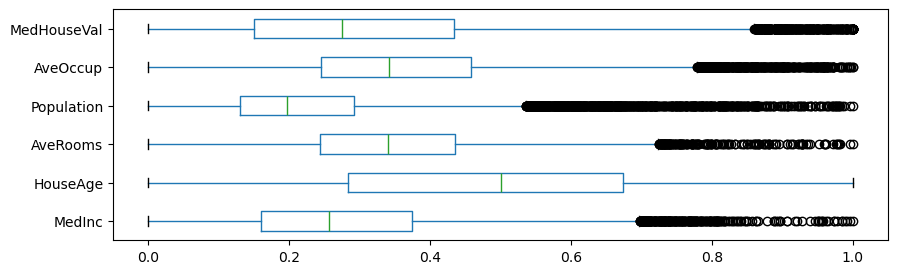

In [33]:
# [TBC] complete your code here with proper comments
# feature scaling
scaler = MinMaxScaler()

preprocessed_data_df = pd.DataFrame(
    scaler.fit_transform(preprocessed_data_df.values),
    columns = preprocessed_data_df.columns
)
preprocessed_data_df.boxplot(
    grid = False,
    figsize = (10, 3),
    vert = False
)
plt.show()

### Task 3. K-Means clustering

<span style="color:red">**[TBC]**</span> Perform K-Means clustering with the pre-processed dataset. Select the value of K through the elbow method.

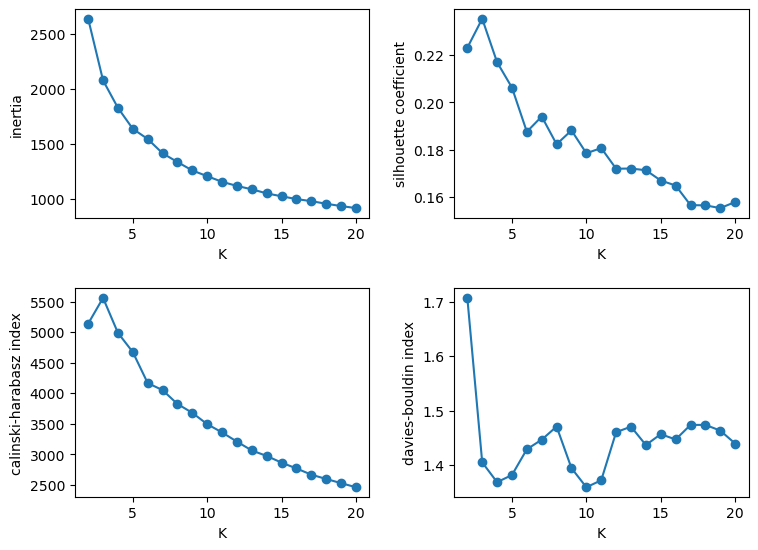

In [34]:
# [TBC] complete your code here with proper comments
X = preprocessed_data_df.values

# create an empty list to store inertia
inertia =[]
silhouette = []
calinski_harabasz = []
davies_bouldin = []

# test different k values
for k in range(2, 21):
    model = KMeans(
        n_clusters = k,
        n_init = 'auto',
        random_state = 1,
        verbose = 0
    ).fit(X)
    inertia.append(model.inertia_)
    silhouette.append(silhouette_score(X, model.labels_))
    calinski_harabasz.append(calinski_harabasz_score(X, model.labels_))
    davies_bouldin.append(davies_bouldin_score(X, model.labels_))

# plot k vs silhouette coefficient
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 6))
fig.tight_layout(pad = 3)
axs[0, 0].plot(range(2, 21), inertia, marker = 'o')
axs[0, 0].set_xlabel('K')
axs[0, 0].set_ylabel('inertia')
axs[0, 1].plot(range(2, 21), silhouette, marker = 'o')
axs[0, 1].set_xlabel('K')
axs[0, 1].set_ylabel('silhouette coefficient')
axs[1, 0].plot(range(2, 21), calinski_harabasz, marker = 'o')
axs[1, 0].set_xlabel('K')
axs[1, 0].set_ylabel('calinski-harabasz index')
axs[1, 1].plot(range(2, 21), davies_bouldin, marker = 'o')
axs[1, 1].set_xlabel('K')
axs[1, 1].set_ylabel('davies-bouldin index')
plt.show()

There is no clear elbow point when using inertia as the metric.

For silhouette coefficient and calinski-harabasz index, K = 3 is the third best value.

For davies-bouldin index, K = 10 is the best value, K = 4 is the second best value.

So let's set K = 3.

In [35]:
# [TBC] complete your code here with proper comments
# reconstruct the clustering model with k = 3
model = KMeans(
    n_clusters = 3,
    n_init = 'auto',
    random_state = 1,
    verbose = 1
)
model.fit(X)

Initialization complete
Iteration 0, inertia 3359.599995764157.
Iteration 1, inertia 2329.421113376343.
Iteration 2, inertia 2272.439829361543.
Iteration 3, inertia 2250.7145276783813.
Iteration 4, inertia 2232.794226094058.
Iteration 5, inertia 2215.4295583317166.
Iteration 6, inertia 2197.2328753581837.
Iteration 7, inertia 2179.5848099006994.
Iteration 8, inertia 2163.635717463007.
Iteration 9, inertia 2150.3469472122624.
Iteration 10, inertia 2137.820002197231.
Iteration 11, inertia 2125.616975220363.
Iteration 12, inertia 2113.97581438862.
Iteration 13, inertia 2103.3635973794444.
Iteration 14, inertia 2094.6115081874295.
Iteration 15, inertia 2089.1298721079575.
Iteration 16, inertia 2085.646683250619.
Iteration 17, inertia 2083.500394123898.
Iteration 18, inertia 2082.1191037967183.
Iteration 19, inertia 2081.37616230039.
Iteration 20, inertia 2080.938320584932.
Iteration 21, inertia 2080.6353879432377.
Iteration 22, inertia 2080.437617882753.
Iteration 23, inertia 2080.32164217

KMeans(n_clusters=3, n_init='auto', random_state=1, verbose=1)

### Task 4. Interpret clustering results

<span style="color:red">**[TBC]**</span> Try to interpret the clustering results using visualization or other methods. Please describe the characteristics of the clusters you've got and which type of districts each cluster represent.

In [36]:
# [TBC] complete your code here with proper comments
# create an interactive 3D scatter plot using plotly
fig = px.scatter_3d(
    preprocessed_data_df,
    x = preprocessed_data_df.columns[0],
    y = preprocessed_data_df.columns[1],
    z = preprocessed_data_df.columns[2],
    color = model.labels_
)
fig.show()

In [37]:
# [TBC] complete your code here with proper comments
# create an interactive 3D scatter plot using plotly
fig = px.scatter_3d(
    preprocessed_data_df,
    x = preprocessed_data_df.columns[3],
    y = preprocessed_data_df.columns[4],
    z = preprocessed_data_df.columns[5],
    color = model.labels_
)
fig.show()

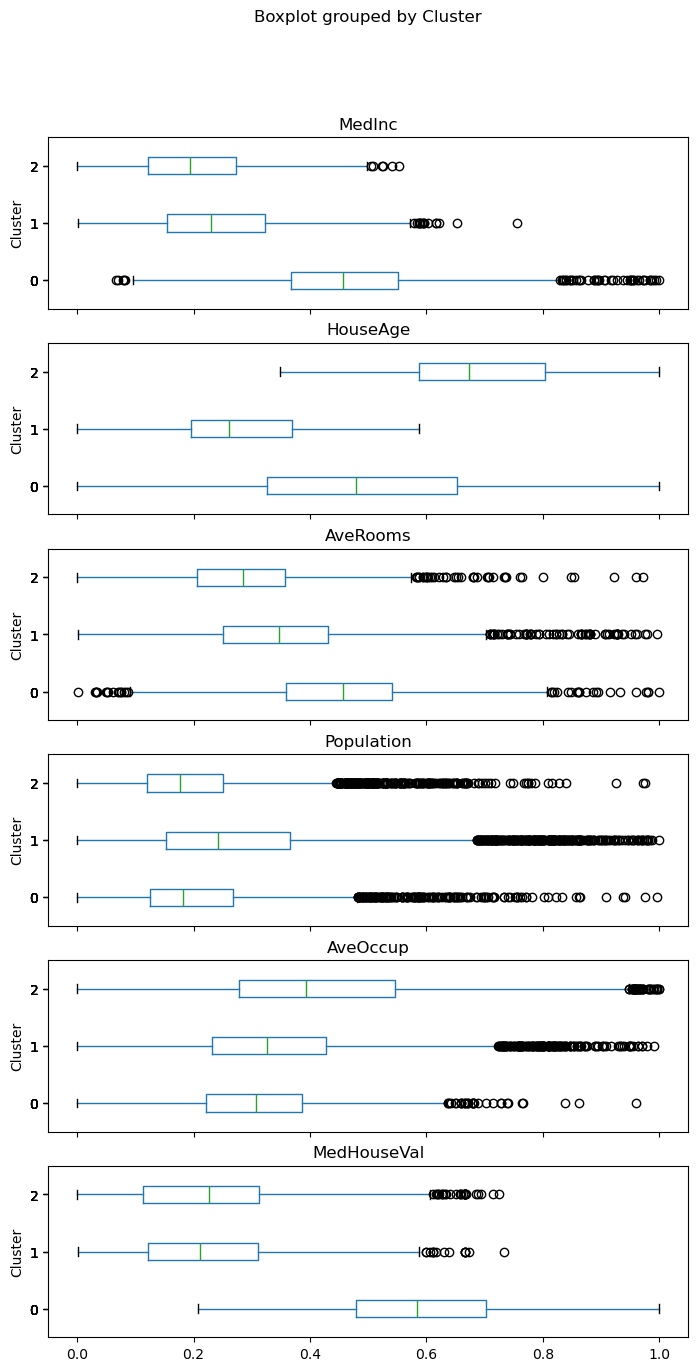

In [38]:
# [TBC] complete your code here with proper comments
# display the boxplot of 'Age', 'Annual Income', 'Spending Score' by cluster
labeled_df = preprocessed_data_df.copy()
labeled_df['Cluster'] = model.labels_
labeled_df.boxplot(
    column = ['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'MedHouseVal'],
    by = 'Cluster',
    grid = False,
    figsize = (8, 16),
    layout = (6, 1),
    vert = False
)
plt.show()

In [39]:
# [TBC] complete your code here with proper comments
# formalize the cluster centroids
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(model.cluster_centers_),
    columns = preprocessed_data_df.columns
)
cluster_centers

,MedInc,HouseAge,AveRooms,Population,AveOccup,MedHouseVal
0,5.486120,27.556176,6.072257,1293.590391,2.714778,3.200950
1,3.376845,17.160066,5.271213,1707.653960,2.846109,1.503716
2,2.985100,36.763925,4.773781,1221.811169,3.169569,1.507222


We got 3 clusters in total. The characteristics of each cluster can be summarized as follows:
- For different clusters, the 'AveOccup' values are all around 3. No significant difference between different districts.
- Cluster 0: Districts with highest income level, median house age, highest average number of rooms per household, and highest house values. The population is around 1300. Such districts can be considered as wealthy districts with large and expensive houses.
- Cluster 1: Districts with median income level, youngest house age, median average number of rooms per household, and relatively low house value. The population is the highest. Such districts can be considered as the newly emerging middle class districts.
- Cluster 2: Districts with lowest income level, oldest house age, lowest average number of rooms per household, and relatively low house value. The population is around 1200. Such districts can be considered as old dilapidated districts with relatively poor citizens.